<a href="https://colab.research.google.com/github/pouyarahmti/Pytorch-Deep-Learning-Bootcamp/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Paper Replicaing

The goal of machine learning paper replicating is: turn a ML research paper into usable code.

In this notebook we are going to replicate Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

In [25]:
import torch
import torchvision


print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [26]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [27]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


## 1. Get Data

We are going to use ViT architecture on our food vision mini data (Pizza, steak, sushi)

In [28]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [29]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and Dataloaders

In [30]:
from torchvision import transforms
from going_modular.going_modular import data_setup


# Image Size
IMG_SIZE = 224 # Comes from table 3 of ViT paper

# Transform
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [31]:
# Batch Size
BATCH_SIZE = 32

# Create Dataloaders
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloaders), len(test_dataloaders), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [32]:
## 2.3 Visualiz a single image

image_batch, label_batch = next(iter(train_dataloaders))

# Get a single Image
img, label = image_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(0))

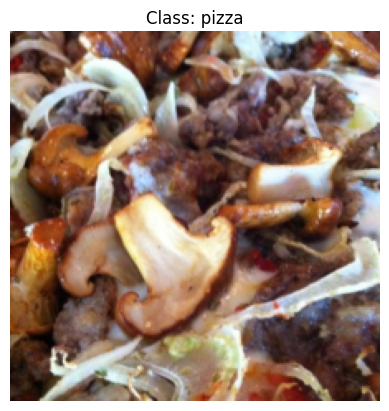

In [33]:
# plot the image with matplotlib
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {class_names[label]}")
plt.axis(False)
plt.show()

## 3. Replication ViT Model

Looking at a whole machine learning research paper can be iدtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT pieces of Puzzle

* Figure 1: Visualize an overview of the ViT architecture
* 4 Equations: math equations which define the function of each layer/block
* Table 1/3: Different hyperparmeters for the architecture/training
* Text




#### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embeddings = Learnable representation (initialized with random numbers and improve over time)

#### 4 Equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-four-equations.png)

#### Table 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-table-1.png)


## 4. Equation 1: Split the data into patches and creating the class, patch and position embeddings

* Layers: Inputs -> Some Function -> Output

what's the input shape?

what's the output shape?

Input shape: (224, 224, 3) -> Single Image

Output shape:


Input Image: $H\times{W}\times{C}$
Output Image: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = number of color channels
* P = Patch size
* N = number of patches = (heigth * width) / $P ^ 2$
* D = Constant latent vector size = embedding size (from table 1)

In [34]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [35]:
# Input shape
embedding_input_shape = (height, width, color_channels)

# Output shape
embedding_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

embedding_input_shape, embedding_output_shape

((224, 224, 3), (196, 768))

In [36]:
# Setup code to plot the whole image in patches

image_size = 224
patch_size = 16
num_patches = image_size / patch_size
assert image_size % patch_size == 0, "Image size must be divisible by patch size"


image_permuted = img.permute(1, 2, 0)

# print(f"Number of patches per row: {num_patches}\
#       \nTotal number of patches: {num_patches * num_patches}\
#       \nPatch size: {patch_size}x{patch_size}"
# )


# fig, axes = plt.subplots(nrows=image_size // patch_size,
#                          ncols=image_size // patch_size,
#                          figsize=(num_patches, num_patches),
#                          sharex=True,
#                          sharey=True)


# for i, patch_height in enumerate(range(0, image_size, patch_size)):
#     for j, patch_width in enumerate(range(0, image_size, patch_size)):
#         axes[i, j].imshow(image_permuted[patch_height:patch_height +patch_size,
#                                          patch_width:patch_width + patch_size, :],)

### 4.2 Creating image patches and embeddings with `torch.nn.Conv2d`

In [37]:
# Create Conv2d Layer to convert image to patches
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, # color channels
                                out_channels=768, # embedding size
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

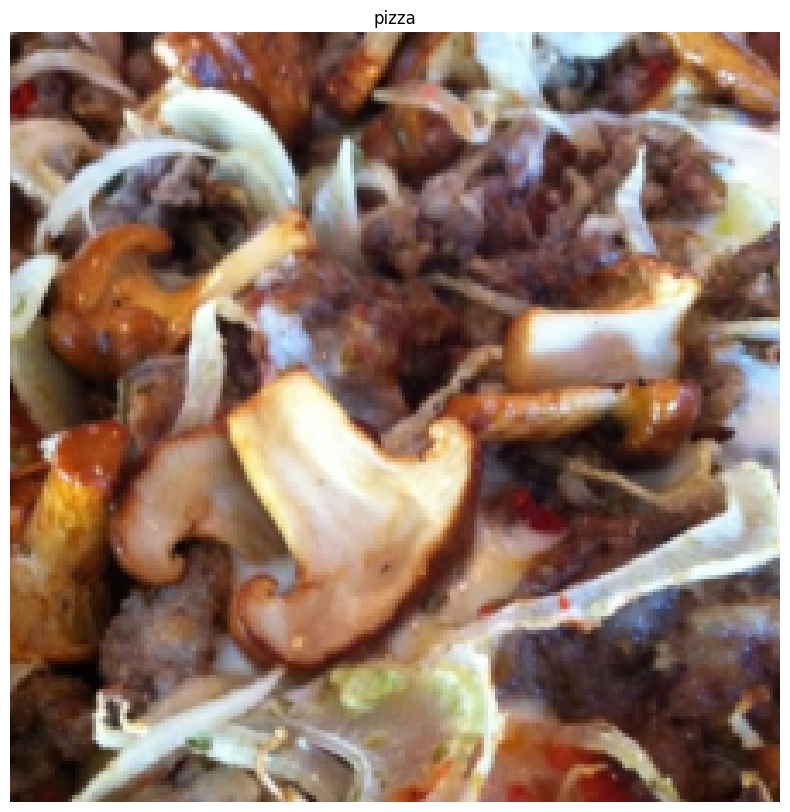

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [39]:
# Pass image through conv2d layer
image_conv = conv2d(img.unsqueeze(0)) # add batch dimension with unsqueeze => (batch_size, in_channels, height, width)
image_conv.shape

torch.Size([1, 768, 14, 14])

In [40]:
### 4.4 Flattening the patches


from torch import nn

flatter_layer = nn.Flatten(start_dim=2, end_dim=3)
flatter_layer

Flatten(start_dim=2, end_dim=3)

In [41]:
# Pass an image into flatten layer

image_flattened = flatter_layer(image_conv)
image_flattened.shape

torch.Size([1, 768, 196])

Image Original Shape: torch.Size([3, 224, 224])
Image Conv2d Shape: torch.Size([1, 768, 14, 14])
Image Flattened Shape: torch.Size([1, 768, 196])


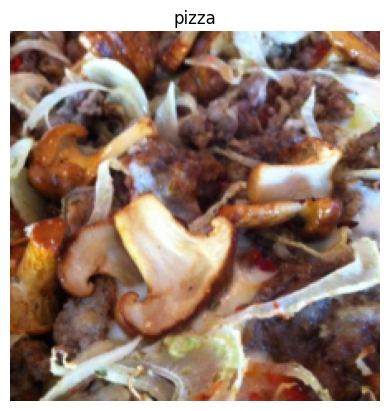

In [42]:
# Put everything together


plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)


print(f"Image Original Shape: {img.shape}")


# Conv2d
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
image_conv = conv2d(img.unsqueeze(0))
print(f"Image Conv2d Shape: {image_conv.shape}")

# Flatten
flatter_layer = nn.Flatten(start_dim=2, end_dim=3)
image_flattened = flatter_layer(image_conv)
print(f"Image Flattened Shape: {image_flattened.shape}")

In [43]:
# Rearrange the output of flatten layer to match ViT

image_flattened = image_flattened.permute(0, 2, 1)
image_flattened.shape

torch.Size([1, 196, 768])

In [44]:
# Visualize the output of the flatten layer

single_flattened_image_feature_map = image_flattened[ :, :, 0]


# Plot
plt.figure(figsize=(10, 10))
plt.imshow(single_flattened_image_feature_map.detach().numpy())
plt.axis(False)

(-0.5, 195.5, 0.5, -0.5)

In [45]:
# Combine layers into single layer

patch_size = 16


patch_embedding_layer = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=768,
              kernel_size=patch_size,
              stride=patch_size,
              padding=0),
    nn.Flatten(start_dim=2, end_dim=3)
)

patch_embedding_layer

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Flatten(start_dim=2, end_dim=3)
)

In [46]:
### 4.5 Turning the ViT Patch Embedding layer into a PyTroch Module